In [81]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [30]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [31]:
df[categorical] = df[categorical].fillna('NA')
df[categorical].isnull().sum()

lead_source          0
industry             0
employment_status    0
location             0
dtype: int64

In [32]:
df[numerical] = df[numerical].fillna(0.0)
df[numerical].isnull().sum()

number_of_courses_viewed    0
annual_income               0
interaction_count           0
lead_score                  0
dtype: int64

In [39]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

del df_train['converted']
del df_val['converted']
del df_test['converted']

## Question 1: ROC AUC feature importance

In [44]:
from sklearn.metrics import roc_auc_score

In [52]:
for col in ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']:
    auc = roc_auc_score(y_train, df_train[col])
    print(f"{col}: {auc:.3f}")

number_of_courses_viewed: 0.764
annual_income: 0.552
interaction_count: 0.738
lead_score: 0.614


## Question 2: Training the model

In [54]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [66]:
train_dicts = df_train[numerical + categorical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [67]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [73]:
val_dicts = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [75]:
pred_auc = roc_auc_score(y_val, y_pred)
round(pred_auc, 3)

0.817

## Question 3: Precision and Recall

In [76]:
from sklearn.metrics import precision_score, recall_score

C:\Users\shaun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\shaun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\shaun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

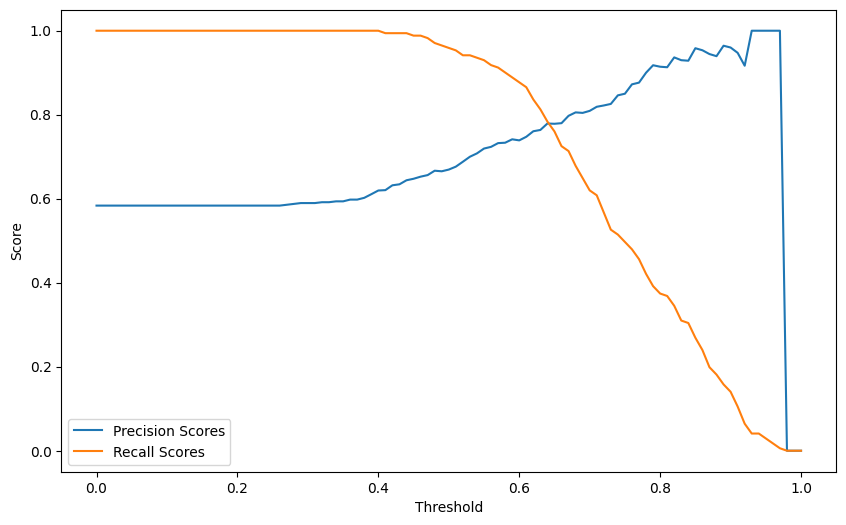

In [83]:
threshold = np.arange(0.0, 1.01, 0.01)

precision_scores = []
recall_scores = []

for t in threshold:

    pred = (y_pred >= t).astype(int)

    precision = precision_score(y_val, pred)
    recall = recall_score(y_val, pred)

    precision_scores.append(precision)
    recall_scores.append(recall)

plt.figure(figsize=(10, 6))
plt.plot(threshold, precision_scores, label='Precision Scores')
plt.plot(threshold, recall_scores, label='Recall Scores')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [108]:
diff = np.array(precision_scores) - np.array(recall_scores)
intersection_index = np.where(np.diff(np.sign(diff)) != 0)[0]
threshold[intersection_index]

array([0.64, 0.97])

## Question 4: F1 score

In [96]:
from sklearn.metrics import f1_score

In [97]:
f1_scores = []
for t in threshold:
    pred = (y_pred >= t).astype(int)

    f1 = f1_score(y_val, pred)
    f1_scores.append(f1)

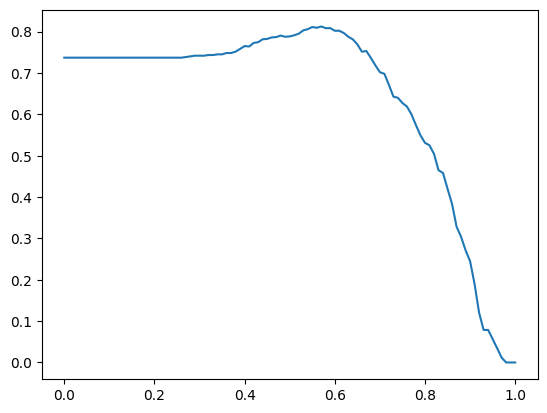

In [98]:
plt.plot(threshold, f1_scores)

In [104]:
f1_index = np.argmax(f1_scores)
round(threshold[f1_index], 2)

0.57

## Question 5: 5-Fold CV

In [109]:
from sklearn.model_selection import KFold

In [112]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    train_dicts = df_train[numerical + categorical].to_dict(orient='records')
    val_dicts = df_val[numerical + categorical].to_dict(orient='records')

    y_train = df_train['converted'].values
    y_val = df_val['converted'].values

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    X_val = dv.transform(val_dicts)

    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [114]:
np.std(scores)

0.03580711942905165

## Question 6: Hyperparameter Tuning

In [120]:
for c in [0.000001, 0.001, 1]:
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        train_dicts = df_train[numerical + categorical].to_dict(orient='records')
        val_dicts = df_val[numerical + categorical].to_dict(orient='records')
    
        y_train = df_train['converted'].values
        y_val = df_val['converted'].values
    
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)
    
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)
    
        X_val = dv.transform(val_dicts)
    
        y_pred = model.predict_proba(X_val)[:, 1]
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(f"C: {c} Mean: {round(np.mean(scores), 3)} Std: {round(np.std(scores), 3)}")

C: 1e-06 Mean: 0.56 Std: 0.024
C: 0.001 Mean: 0.867 Std: 0.029
C: 1 Mean: 0.822 Std: 0.036
